# Setup

In [2]:
if (!require("xfun")) install.packages("xfun")
pkgs <- c(
  'forecast', 'vars', 'urca', 'MLmetrics', 
  'lubridate', 'tsbox', 'timetk',
  'extrafont', 'patchwork', 'hrbrthemes', 'ggthemes', 'ggsci', 'scales', 
  'tidyverse', 'vroom', 'readxl', 'writexl', 'tsibble'
)
xfun::pkg_attach2(pkgs, message = FALSE)

options(
  repr.plot.width=10, 
  repr.plot.height=6, 
  repr.plot.res = 300,
  repr.matrix.max.rows = 10,
  repr.matrix.max.cols = Inf
)

loadfonts(device = "win", quiet = TRUE)

# Load Data

In [88]:
# rice 
rice_m <- read_csv('../data/clean/rice_m.csv')
rice_m_ts <- rice_m %>% 
  select(date, ex_white, ex_hommali) %>%
  as_tsibble(index = date) %>% ts_ts()
rice_m_xts <- rice_m_ts %>% ts_xts()

# rice_price
price <- read_csv("../data/raw/rice_price.csv") %>%
  filter(year(date) < 2020) %>%
  select(date, p_w5_th, p_w5_vn, p_h100_th)
price_ts <- price %>% as_tsibble(index = date) %>% ts_ts()
price_xts <- price %>% as_tsibble(index = date) %>% ts_xts()

# exogenious population and gdp of world
exo <- read_csv("../data/raw/wdi_exo.csv")
exo_ts <- exo %>% as_tsibble(index = date) %>% ts_ts()
exo_xts <- exo %>% as_tsibble(index = date) %>% ts_xts()

# combine
data <- ts_c(rice_m_xts, price_xts, exo_xts)["2003-01-01/"]
data <- data %>% na.locf() # fill forward


-- Column specification -------------------------------------------------------------------------------------------------------
cols(
  year_th = col_double(),
  month = col_character(),
  ex_glutinous = col_double(),
  ex_white = col_double(),
  ex_hommali = col_double(),
  ex_pathum = col_double(),
  ex_colored = col_double(),
  date = col_date(format = "")
)


[time]: 'date' 


-- Column specification -------------------------------------------------------------------------------------------------------
cols(
  date = col_date(format = ""),
  p_w25_ind = col_double(),
  p_w25_vn = col_double(),
  p_w25_th = col_double(),
  p_h100_th = col_number(),
  p_w5_th = col_double(),
  p_w5_vn = col_double()
)


[time]: 'date' 

[time]: 'date' 


-- Column specification -------------------------------------------------------------------------------------------------------
cols(
  date = col_date(format = ""),
  gdppc = col_number(),
  pop = col_number()
)


[time]: 'date' 

[time]: 'date' 



In [96]:
# log transformation
ex_hommali <- data[, 'ex_hommali'] %>% log()
ex_white <- data[, 'ex_white'] %>% log()
p_w5_th <- data[, 'p_w5_th'] %>% log()
p_w5_vn <- data[, 'p_w5_vn'] %>% log()
p_h100_th <- data[, 'p_h100_th'] %>% log()
gdppc <- data[, 'gdppc'] %>% log()
pop <- data[, 'pop'] %>% log()

vars_list = list(
  ex_hommali = ex_hommali, 
  ex_white = ex_white, 
  p_w5_th = p_w5_th, 
  p_w5_vn = p_w5_vn, 
  p_h100_th = p_h100_th
)

In [111]:
# ex_hommali

# Data Visualization

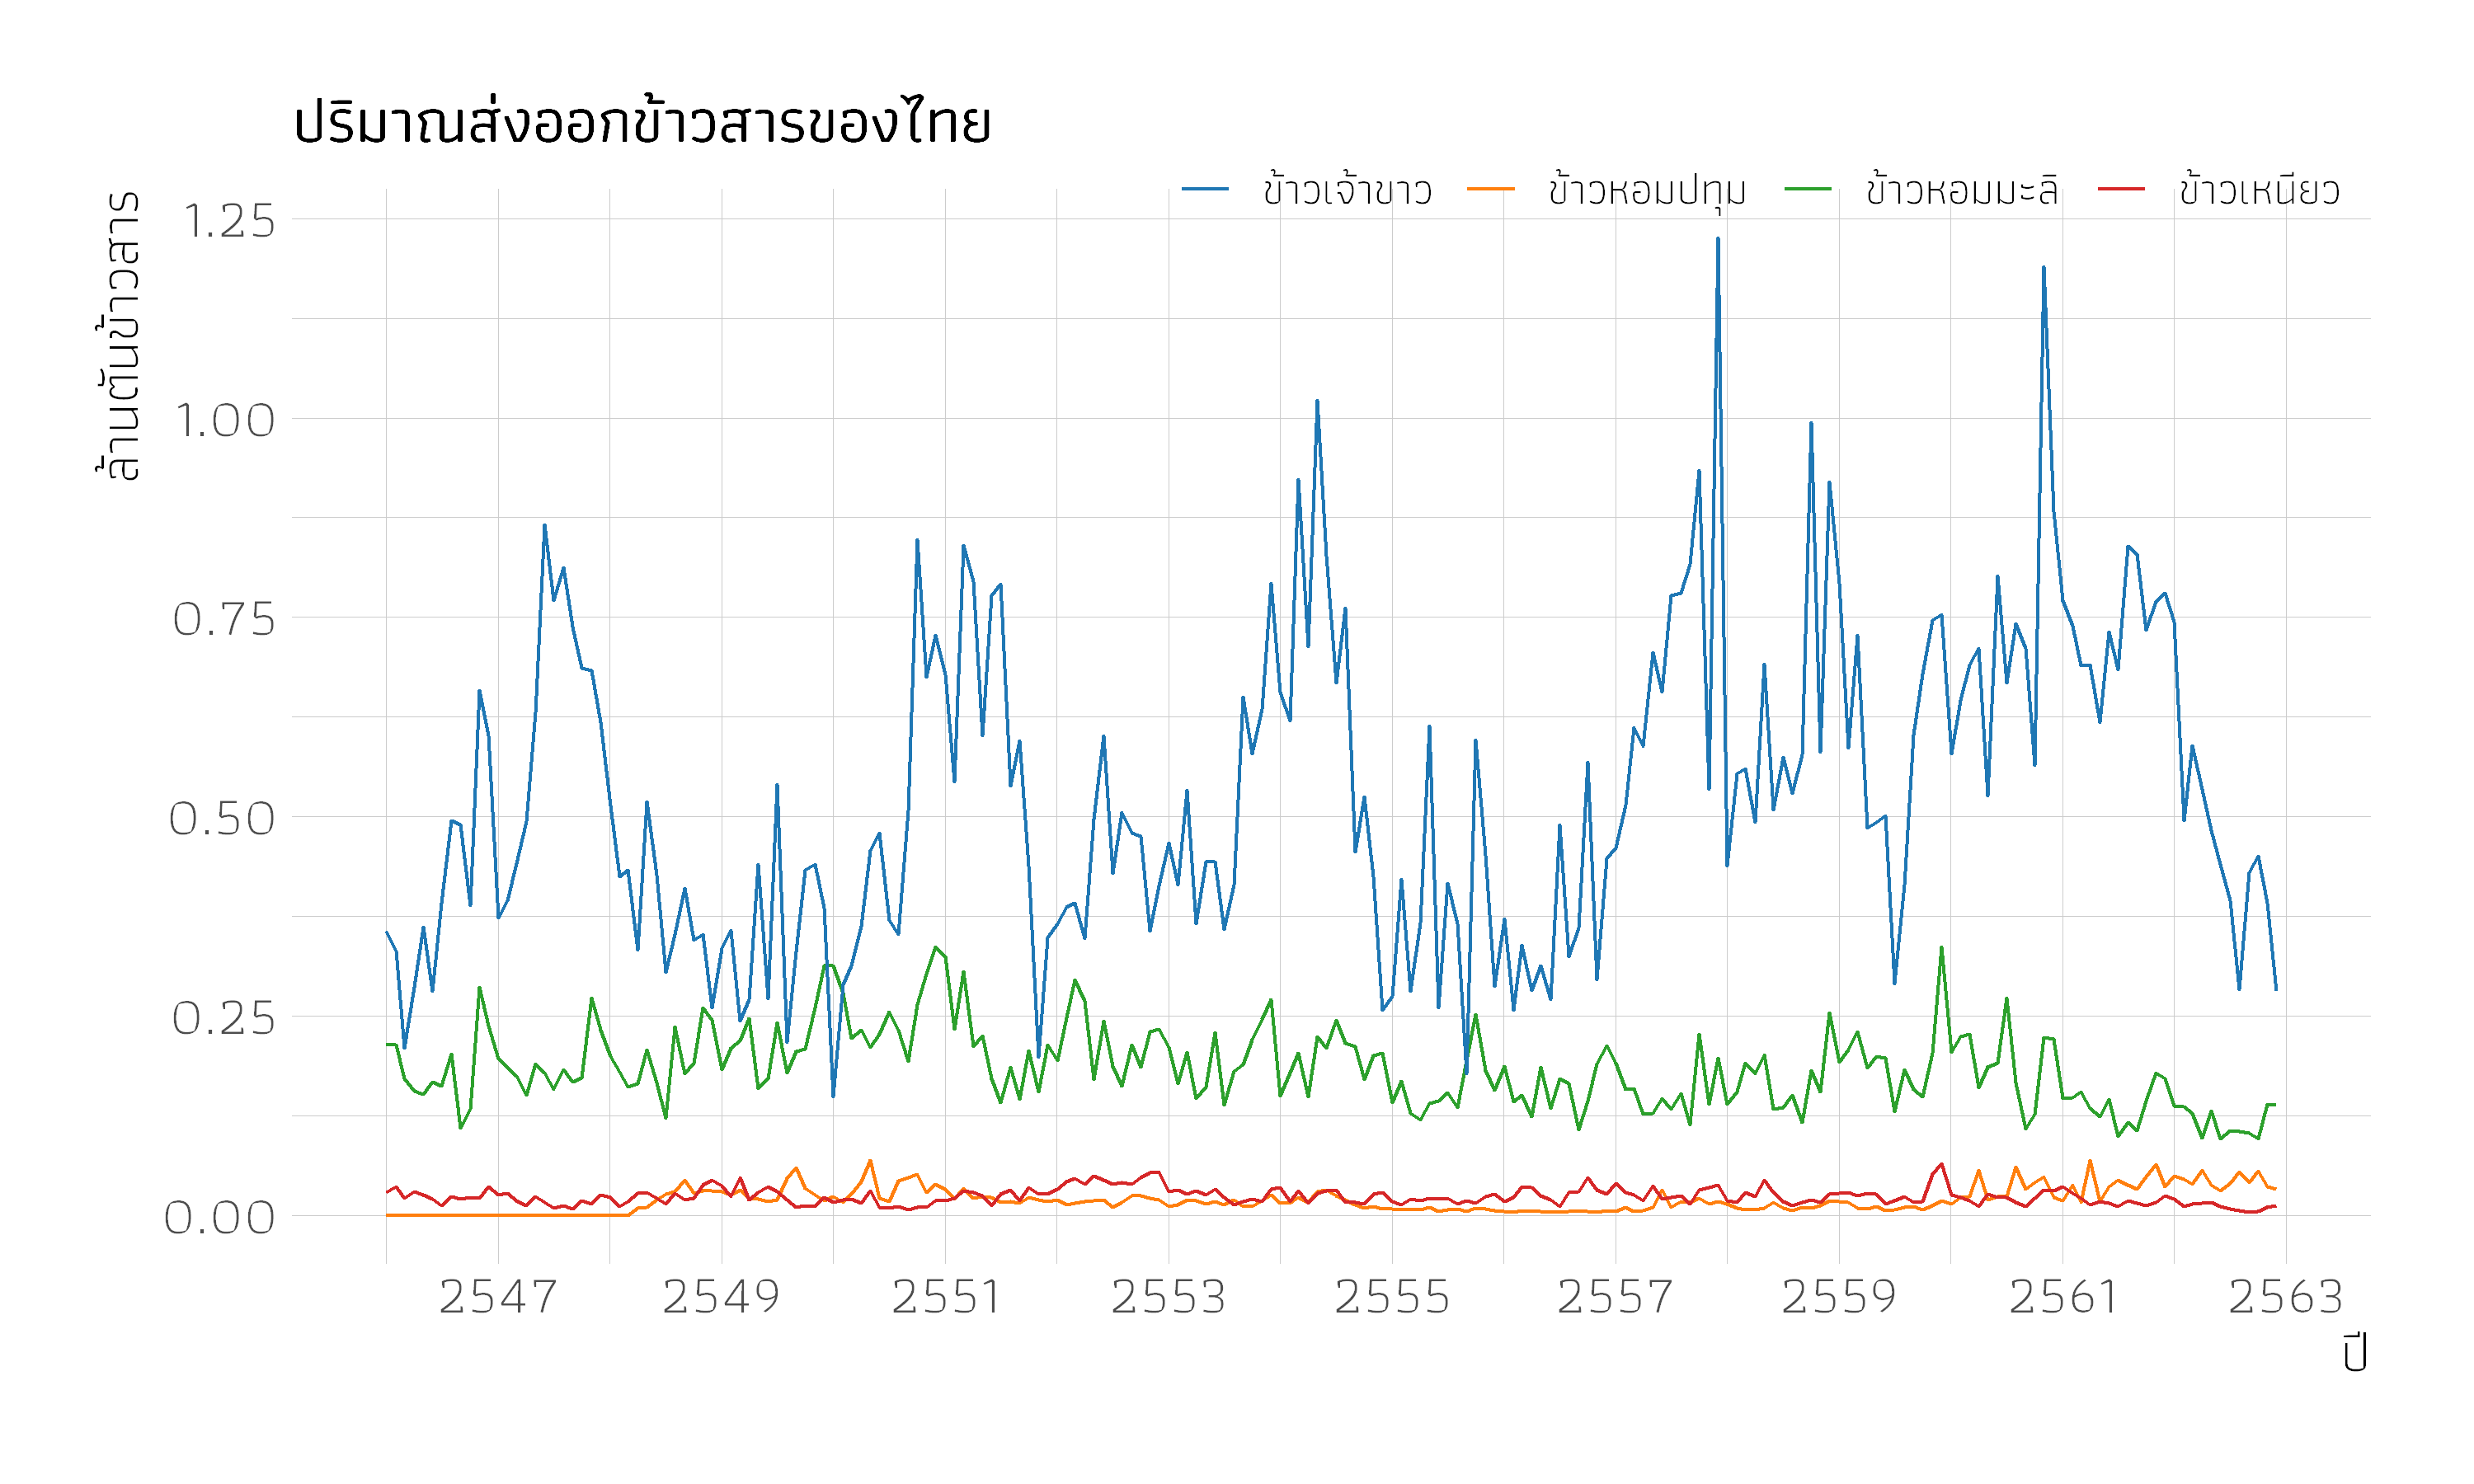

In [4]:
ggplot(rice_m %>% filter(year_th >= 2546), aes(x=date)) +
  geom_line( aes(y=ex_hommali/1e6, color = 'ข้าวหอมมะลิ')) +
  geom_line( aes(y=ex_pathum/1e6, color = 'ข้าวหอมปทุม')) +
  geom_line( aes(y=ex_white/1e6, color = 'ข้าวเจ้าขาว')) +
  geom_line( aes(y=ex_glutinous/1e6, color = 'ข้าวเหนียว')) +
  scale_color_d3() +
  expand_limits(y = 0) +
  scale_y_continuous(label = comma) +
  labs(
    title = 'ปริมาณส่งออกข้าวสารของไทย',
    x =  "ปี", y = 'ล้านตันข้าวสาร'
  ) +
  theme_ipsum(
    base_size = 16,
    base_family = "Athiti Light",
    axis_title_size = 16
  ) +
  theme(
    legend.position = c(1, 1),
    legend.direction = 'horizontal',
    legend.justification = 'right',
    legend.title = element_blank()
  ) +
  scale_x_date(
    date_breaks = '2 years',
    labels = function(x) year(x)+543
  )
# ggsave('../figures/plot_export_m.png', width = 10, height = 7)

# Unit Root Test

In [116]:
ur_adf(ex_hommali) %>% adf_table

In [119]:
get_objname <- function(x) deparse(substitute(x))

ur_adf <- function(y, n_diff = 0, varname = NULL, ...) {
  
  varname <- if (is.null(varname)) deparse(substitute(y)) else varname
  y <- y %>% ts_ts()
  y <- if(n_diff == 0) y else diff(y, n_diff)
  
  ur.trend <- ur.df(y, type='trend', lags = 10, selectlags = "BIC", ...)
  ur.drift <- ur.df(y, type='drift', lags = 10, selectlags = "BIC", ...)
  ur.none  <- ur.df(y, type='none' , lags = 10, selectlags = "BIC", ...)

  tstat.trend <- ur.trend@teststat
  tstat.drift <- ur.drift@teststat
  tstat.none  <- ur.none@teststat

  cv.trend <- ur.trend@cval
  cv.drift <- ur.drift@cval
  cv.none  <- ur.none@cval
  
  lags.trend <- dim(ur.trend@testreg$coefficients)[1] - 3
  lags.drift <- dim(ur.drift@testreg$coefficients)[1] - 2
  lags.none  <- dim(ur.none@testreg$coefficients)[1]  - 1

  df_test = rbind(
    cbind(t(tstat.trend), cv.trend, lags.trend),
    cbind(t(tstat.drift), cv.drift, lags.drift),
    cbind(t(tstat.none) , cv.none , lags.none)
  ) %>% 
  as.data.frame() %>%
  rename(c("lag" = "lags.trend")) %>%
  rownames_to_column("hypo") %>%
  filter(str_starts(hypo, 'tau')) %>%
  mutate(
    result = ifelse(abs(statistic) >= abs(`5pct`), 'Reject', 'Accept'),
    variable = varname,
    level = paste0('d', n_diff),
    star = case_when(
      abs(statistic) > abs(`1pct`) ~ "***",
      abs(statistic) > abs(`5pct`) ~ "** ",
      abs(statistic) > abs(`10pct`) ~ "*  ",
      TRUE ~ "   "
    ),
    hypo = case_when(
      hypo == "tau3" ~ "trend",
      hypo == "tau2" ~ "constant",
      hypo == "tau1" ~ "none"
    ),
    statistic = format(round(statistic, 2), nsmall = 2) %>% 
      as.character %>% str_pad(6, "left")
  ) %>%
  select(variable, hypo, level, everything())
  
  return(df_test)
}

adf_table <- function(ur_adf) {
  ur_adf %>%
    mutate(
      stat_star = glue::glue(
        "{statistic}{star}({lag})"
      ) %>% as.character()
    ) %>%
    pivot_wider(
      id_cols = c("variable"),
      names_from = c("level", "hypo"),
      values_from = c("stat_star")
    )
}

In [120]:
varnames = rep(names(vars_list), 1)

params = expand_grid(varnames, c(0,1)) %>%
  set_names(c('names', 'ndiff')) %>%
  mutate(ser = vars_list[names])

In [121]:
adf_table_result <- pmap(list(params$ser, params$ndiff, params$names), 
     function(first, second, third) {
       ur_adf(first, second, third)
     }) %>% 
  reduce(rbind) %>% adf_table()

# adf_table_result %>% write_xlsx('../results/adf_table.xlsx')

# Forecast
1. Split train test
2. Define forecast function
3. Define rolling forecast function
4. Define gridsearch function


In [136]:
split_traintest <- function(data, 
                            prop_train = NULL, 
                            n_train = NULL) {
  n <- length(data)
  n_train <- ifelse(is.null(n_train), round(n*0.8), n_train)
  attr(data, "train") <- data[1:n_train]
  attr(data, "test") <- data[n_train:n]
#   attr(data, "train") <- data %>% window(end = end_train)
#   attr(data, "test") <- data %>% window(start = end_train)
  return(data)
}

ex_hommali_ <- split_traintest(ex_hommali, n_train = 14*12)

In [139]:
# attr(ex_hommali_, "train")

In [150]:
params <- list(
  model = "ZZZ",
  damped = TRUE
)
params$y <- ex_hommali[1:168]
result <- do.call(ets, params)

In [182]:
x <- result %>% 
  forecast(10) %>% 
  as.data.frame() %>% 
  select('Point Forecast') %>%
  t() %>% as.data.frame() %>% exp()

colnames(x) <- paste0('yhat_', seq(1:10))
# rownames(x) <- 168
x

,yhat_1,yhat_2,yhat_3,yhat_4,yhat_5,yhat_6,yhat_7,yhat_8,yhat_9,yhat_10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Point Forecast,211870.2,211878.8,211885.7,211891.2,211895.6,211899.2,211902,211904.2,211906.1,211907.5


In [146]:
coef(result)

alpha          beta           phi             l             b 
 0.2953858485  0.0001000004  0.8000003864 12.4788192616 -0.0881662736

In [144]:
str(result$fit)

List of 4
 $ value  : num 350
 $ par    : num [1:5] 0.2954 0.0001 0.8 12.4788 -0.0882
 $ fail   : int 0
 $ fncount: int 569


In [ ]:
ets_forecast <- function() {
  
}

In [69]:
params$y <- ex_hommali

In [ ]:
params